## Introduction

This notebook examines the relationship between wind generation forecast error and day-ahead quarter-hourly electricity prices in the DE-LU bidding zone.  
We use two datasets from the ENTSO-E Transparency Platform:  
(1) day-ahead price data, and  
(2) onshore wind generation data containing forecast, intraday updates, and actual output.  
These are merged on their common MTU timestamps to form a unified dataset for analysis.

The goal is to quantify how deviations between forecast and actual wind production affect short-term price movements.  


## Import Libraries and Data

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import numpy as np


data_file1 = Path("..") / "data" / "GUI_ENERGY_PRICES_202512010000-202512020000.csv"
data_file2 = Path("..") / "data" / "GUI_WIND_SOLAR_GENERATION_FORECAST_ONSHORE_202512010000-202512020000.csv"

#Create Price Dataframe
df_price = pd.read_csv(data_file1).drop(columns={"Intraday Period (UTC)", "Intraday Price (EUR/MWh)", "Sequence"})
#Create Wind Dataframe
df_wind = pd.read_csv(data_file2)
#Merge Dataframes
df = pd.merge(df_price, df_wind)
#Drop sequence 2 so there is only one price per timestamp
df = df.drop_duplicates(subset=["MTU (UTC)"], keep="first").copy()

df.head()

,MTU (UTC),Area,Day-ahead Price (EUR/MWh),Day-ahead (MW),Intraday (MW),Current (MW),Actual (MW)
0,01/12/2025 00:00:00 - 01/12/2025 00:15:00,BZN|DE-LU,90.79,15025.99,16996.48,16996.48,17656.78
2,01/12/2025 00:15:00 - 01/12/2025 00:30:00,BZN|DE-LU,85.05,14740.55,17040.32,17040.32,17590.58
4,01/12/2025 00:30:00 - 01/12/2025 00:45:00,BZN|DE-LU,85.46,14492.43,17050.23,17050.23,17313.54
6,01/12/2025 00:45:00 - 01/12/2025 01:00:00,BZN|DE-LU,82.79,14265.44,16992.20,16992.20,16981.11
8,01/12/2025 01:00:00 - 01/12/2025 01:15:00,BZN|DE-LU,85.03,14100.01,16815.53,16815.53,16753.76


## Compute Forecast error

In [3]:
df["Day-ahead forecast error (MW)"] = df["Actual (MW)"] - df["Day-ahead (MW)"]
df["Intraday forecast error (MW)"] = df["Actual (MW)"] - df["Intraday (MW)"]

## Plotting Forecast Error agaisnt time
Note: As data points of forecast error are discrete the line connecting data points is simply for visualisation and doesnt reflect where the error is and time between time steps

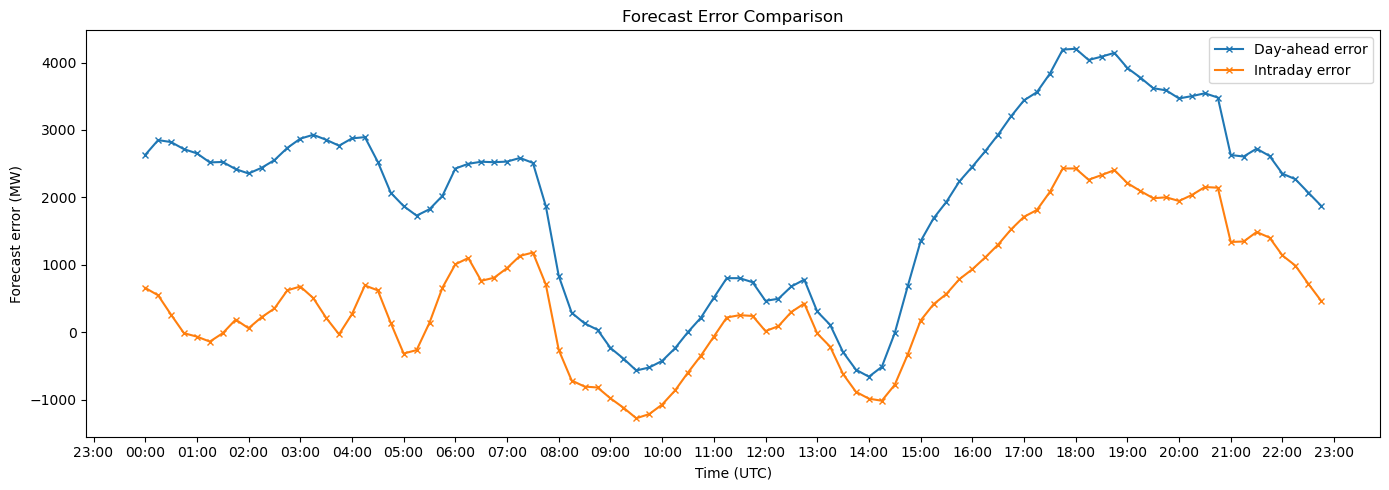

In [ ]:
# Strip MTU (UTC) to just hours and minutes for visualisation
time = pd.to_datetime(
    df["MTU (UTC)"].str.split(" - ").str[0],
    format="%d/%m/%Y %H:%M:%S"
)

x = mdates.date2num(time)

plt.figure(figsize=(14, 5))

plt.plot(
    x,
    df["Day-ahead forecast error (MW)"],
    linestyle="-",
    marker="x",
    markersize=5,
    label="Day-ahead error"
)

plt.plot(
    x,
    df["Intraday forecast error (MW)"],
    linestyle="-",
    marker="x",
    markersize=5,
    label="Intraday error"
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 25)))

plt.xlabel("Time (UTC)")
plt.ylabel("Forecast error (MW)")
plt.title("Forecast Error Comparison")
plt.legend()
plt.tight_layout()
plt.show()


## Plotting Forecast Error agaisnt Day-ahead Price

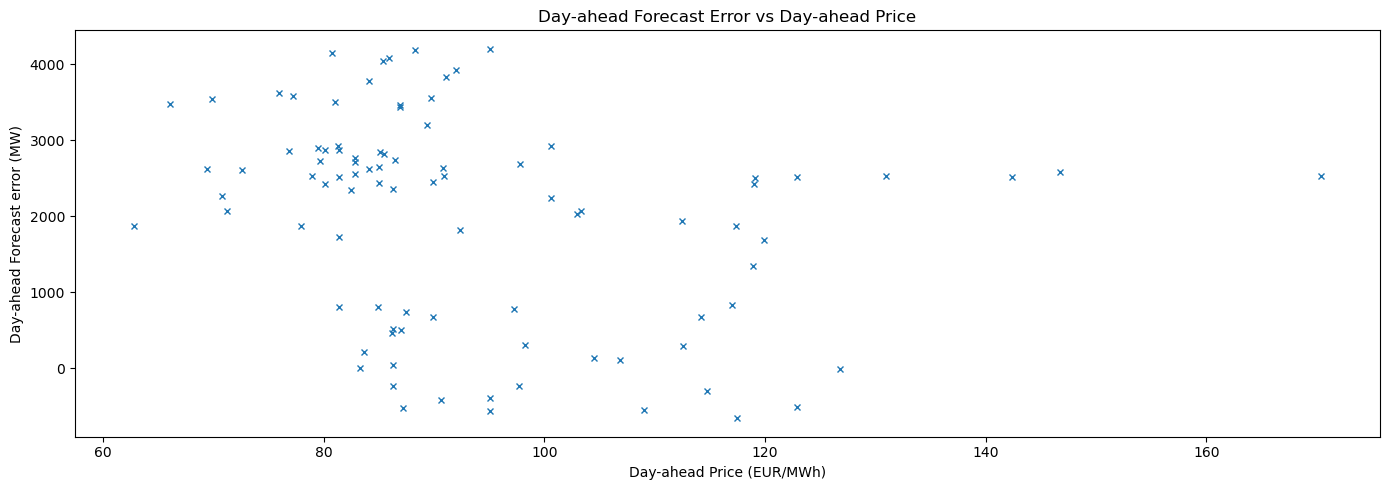

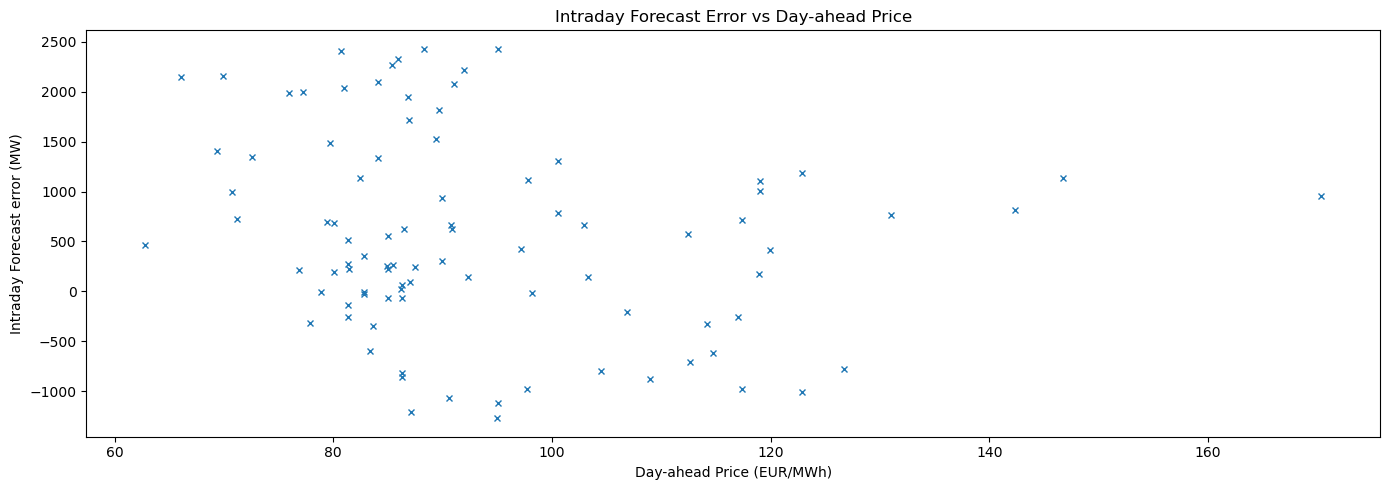

In [5]:
plt.figure(figsize=(14, 5))
plt.plot(
    df["Day-ahead Price (EUR/MWh)"],
    df["Day-ahead forecast error (MW)"],
    marker="x",
    linestyle="",
    markersize=5
)
plt.xlabel("Day-ahead Price (EUR/MWh)")
plt.ylabel("Day-ahead Forecast error (MW)")
plt.title("Day-ahead Forecast Error vs Day-ahead Price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(
    df["Day-ahead Price (EUR/MWh)"],
    df["Intraday forecast error (MW)"],
    marker="x",
    linestyle="",
    markersize=5
)
plt.xlabel("Day-ahead Price (EUR/MWh)")
plt.ylabel("Intraday Forecast error (MW)")
plt.title("Intraday Forecast Error vs Day-ahead Price")
plt.tight_layout()
plt.show()

## Regression: Day-ahead Price vs Day-ahead Wind Forecast Error

We fit a linear model linking quarter-hourly day-ahead prices to day-ahead wind forecast error.  
The estimated relationship is:


$ P_t = 100.62 - 0.0035\,E^{DA}_t $,


with the forecast-error coefficient significant at the 5 percent level (p = 0.012).  
The slope implies that for every 1 MW of wind shortfall, the day-ahead price increases by approximately 0.0035 EUR/MWh, and conversely, for every 1 MW of surplus wind, the price decreases by the same amount.  
The negative slope reflects the expected physical effect: excess wind lowers prices, while wind shortfalls lift them.  



In [6]:
# Define Variables
x_da = df["Day-ahead forecast error (MW)"]
y_da = df["Day-ahead Price (EUR/MWh)"]

X_da = sm.add_constant(x_da)

#Fit OLS
model_da = sm.OLS(y_da, X_da).fit()

print(model_da.summary())

                                OLS Regression Results                               
Dep. Variable:     Day-ahead Price (EUR/MWh)   R-squared:                       0.068
Model:                                   OLS   Adj. R-squared:                  0.058
Method:                        Least Squares   F-statistic:                     6.582
Date:                       Thu, 11 Dec 2025   Prob (F-statistic):             0.0120
Time:                               14:10:26   Log-Likelihood:                -395.86
No. Observations:                         92   AIC:                             795.7
Df Residuals:                             90   BIC:                             800.8
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

## Regression: Day-ahead Price vs Intraday Wind Forecast Error

We also regress day-ahead prices on the intraday forecast error, which reflects updated expectations closer to delivery.  
The estimated model is:


$P_t = 95.66 - 0.0037\,E^{ID}_t$,

with the coefficient marginally insignificant at the 5 percent level (p ≈ 0.064).  
The slope again indicates that each 1 MW of unexpected wind decrease raises the price by roughly 0.0037 EUR/MWh similar to the day-ahead forecast error, and surplus wind lowers it by the same amount.

The weaker significance relative to the day-ahead error likely reflects the limited sample of just a single day and the fact that intraday forecast revisions are more reactive and noisier.  


In [7]:
x_id = df["Intraday forecast error (MW)"]

X_id = sm.add_constant(x_id)
model_id = sm.OLS(y_da, X_id).fit()

print(model_id.summary())


                                OLS Regression Results                               
Dep. Variable:     Day-ahead Price (EUR/MWh)   R-squared:                       0.038
Model:                                   OLS   Adj. R-squared:                  0.027
Method:                        Least Squares   F-statistic:                     3.527
Date:                       Thu, 11 Dec 2025   Prob (F-statistic):             0.0636
Time:                               14:12:28   Log-Likelihood:                -397.34
No. Observations:                         92   AIC:                             798.7
Df Residuals:                             90   BIC:                             803.7
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

## Directional Trading Signal Based on Forecast Error

We construct a simple directional signal by taking the sign of the day-ahead wind forecast error:


$ S_t = \text{sign}(E^{DA}_t)$,


where a negative error (wind deficit) generates a bullish signal and a positive error (wind surplus) a bearish one.  
We compare this signal to the subsequent price change:


$ \Delta P_t = P_{t+1} - P_t$,


and compute hit rate and cumulative PnL.  
The hit rate measures how often the signal correctly anticipates the direction of the next price move, while the PnL evaluates the realised return per MW assuming a one-unit position.
Across the quarter-hourly samples for the day, the signal achieves:

- **Hit Rate:** 0.55  
- **Total PnL:** 1.89 EUR/MWh  
- **Avg price move when signal = −1 (wind deficit, bullish):** −1.358 EUR/MWh  
- **Avg price move when signal = +1 (wind surplus, bearish):** −0.163 EUR/MWh  

These results show that the signal just about outperforms random direction, with positive cumulative PnL.  
But interestingly we only make money when we short the price when there is a surplus which we can see from the first figure occurs far more often then there being a deficit for this day. It is interesting that we lose when buying at the price when bullish by a factor of ten.

In [ ]:
#Get values from df as an array
prices = df["Day-ahead Price (EUR/MWh)"].values
forecast_error = df["Day-ahead forecast error (MW)"].values

#Compute whether the forecast is positive or negative
signal = np.sign(forecast_error)

#Compute the change in price between time steps
price_change = np.diff(prices)
price_change = np.append(price_change, np.nan)   

#Calculate PnL for the strategy
pnl = signal * price_change

signal = signal[:-1]
price_change = price_change[:-1]
pnl = pnl[:-1]

#Calculate number of successful trades
hit = (signal * price_change > 0).astype(int)
hit_rate = hit.mean()

total_pnl = pnl.sum()
bullish_avg = price_change[signal == -1].mean()  
bearish_avg = price_change[signal == 1].mean()   

print("Hit Rate: {:.2f}".format(hit_rate))
print("Total PnL: {:.2f} EUR/MWh".format(total_pnl))
print("Avg price move when signal = -1 (wind deficit, bullish): {:.3f}".format(bullish_avg))
print("Avg price move when signal = +1 (wind surplus, bearish): {:.3f}".format(bearish_avg))



Hit Rate: 0.55
Total PnL: 1.89 EUR/MWh
Avg price move when signal = -1 (wind deficit, bullish): -1.358
Avg price move when signal = +1 (wind surplus, bearish): -0.163


## Three-bin Regime

To capture non-linear market behaviour, the day-ahead wind forecast error is partitioned into three regimes using the 33% and 66% quantiles. These bins represent:

1. **Low forecast error**
2. **Medium forecast error**
3. **High forecast error** 

For each bin, we estimate the conditional mean and volatility of the next quarter-hour price change:

- **Mean ΔP:** {Low Forecast Error: 0.085, Medium Forecast Error: –0.158, High Forecast Error: –0.832} EUR/MWh  
- **Volatility:** {Low Forecast Error: 6.42, Medium Forecast Error: 12.86, High Forecast Erro: 5.96} EUR/MWh

The key insight is that High Forecast Error exhibits both the **largest directional move** and the smallest **volatility**, producing the strongest negative signal-to-noise ratio (SNR).  


In [ ]:
# Obatin error array
E = df["Day-ahead forecast error (MW)"].values

# Align the lengths to price change
E = E[1:]  

#Define quantile
q33 = np.quantile(E, 0.33)
q66 = np.quantile(E, 0.66)

def assign_bin(e):
    if e < q33:
        return 1  
    elif e <= q66:
        return 2  
    else:
        return 3   

#Assign errors to one of 3 bins
bins = np.array([assign_bin(e) for e in E])

valid = ~np.isnan(price_change)
E = E[valid]
bins = bins[valid]
price_change = price_change[valid]

mu = {}
sigma = {}

for k in [1, 2, 3]:
    dp_k = price_change[bins == k]
    mu[k] = dp_k.mean()
    sigma[k] = dp_k.std()


SNR = {k: mu[k] / sigma[k] for k in [1, 2, 3]}

print(f"Bin cutoffs: q33 = {q33:.2f}, q66 = {q66:.2f}")
print("Conditional means:", mu)
print("Conditional volatilities:", sigma)
print("Signal-to-noise ratios:", SNR)


Bin cutoffs: q33 = 1718.74, q66 = 2638.73
Conditional means: {1: 0.08499999999999991, 2: -0.1576666666666668, 3: -0.8325806451612904}
Conditional volatilities: {1: 6.419883046702121, 2: 12.861627342171323, 3: 5.96213913102419}
Signal-to-noise ratios: {1: 0.013240116584937511, 2: -0.012258687215240776, 3: -0.1396446186283928}


## Plotting the Mean Price Change, Volatility and SNR for the 3 Regimes

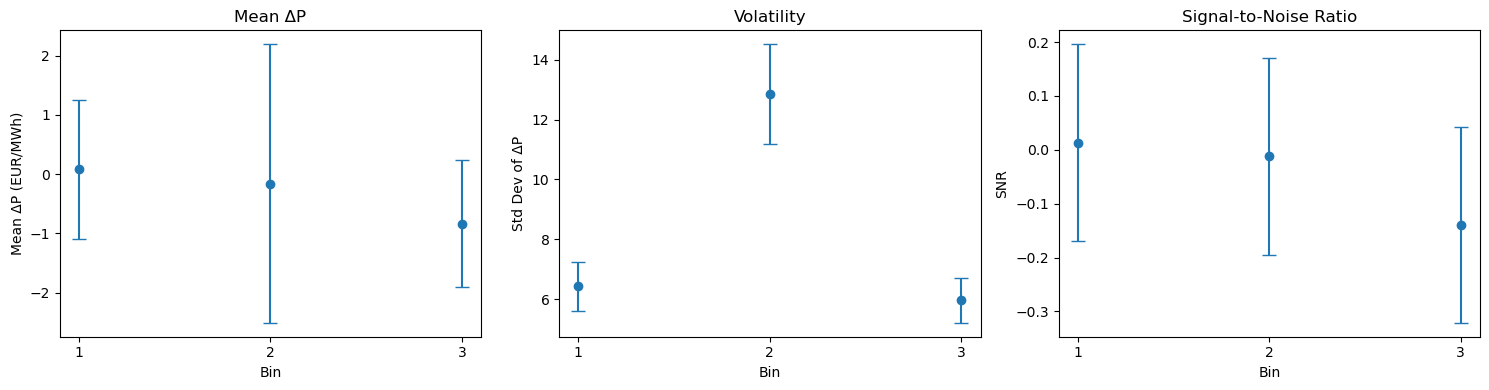

In [19]:
mu_list = [mu[1], mu[2], mu[3]]
sigma_list = [sigma[1], sigma[2], sigma[3]]
snr_list = [SNR[1], SNR[2], SNR[3]]

n_list = [
    sum(bins == 1),
    sum(bins == 2),
    sum(bins == 3)
]

sem_list = [sigma_list[i] / np.sqrt(n_list[i]) for i in range(3)]

vol_err = [sigma_list[i] / np.sqrt(2 * n_list[i]) for i in range(3)]

snr_err = [
    np.sqrt((sigma_list[i]**2 + mu_list[i]**2) / (sigma_list[i]**2 * n_list[i]))
    for i in range(3)
]

bins_list = [1, 2, 3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].errorbar(
    bins_list, mu_list, yerr=sem_list,
    fmt='o', capsize=5
)
axes[0].set_title("Mean ΔP")
axes[0].set_xlabel("Bin")
axes[0].set_ylabel("Mean ΔP (EUR/MWh)")
axes[0].set_xticks([1, 2, 3])

axes[1].errorbar(
    bins_list, sigma_list, yerr=vol_err,
    fmt='o', capsize=5
)
axes[1].set_title("Volatility")
axes[1].set_xlabel("Bin")
axes[1].set_ylabel("Std Dev of ΔP")
axes[1].set_xticks([1, 2, 3])

axes[2].errorbar(
    bins_list, snr_list, yerr=snr_err,
    fmt='o', capsize=5
)
axes[2].set_title("Signal-to-Noise Ratio")
axes[2].set_xlabel("Bin")
axes[2].set_ylabel("SNR")
axes[2].set_xticks([1, 2, 3])

plt.tight_layout()
plt.show()


## Conclusion

This project explores how wind forecast errors relate to German day-ahead power prices. Even using a single day of data, we observe a pattern: when actual wind exceeds the forecast, prices tend to fall, and when wind underperforms, prices tend to rise. A simple sign-based trading rule produces a hit rate slightly above random, and a three-bin regime model shows that larger forecast errors correspond to more negative expected price moves.

## Limitations and Next Steps

The main limitation is that the analysis uses only one trading day, which limits the number of data points available to draw robust conclusions. To draw meaningful quantitative conclusions, the study must be extended across multiple days or weeks, covering a range of market states. With more data, we can stabilise the regressions and test whether the predictive relationships persist out of sample.

